# Exploration Lesson

### Goals:

- Can we see patterns, find signals in the data?

- What features are driving the outcome?

- Are there other features we can construct that have stronger relationships?

- Use visualization and statistical testing to help answer these questions.

- We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods).

### Scenario:

We would like to be able to use attributes of customers to estimate their spending score. In doing so, we can target those customers that are likely to be most profitable for us. Our target variable is spending_score. Currently the only customer data we have available to use in this project is age, annual_income and gender. It is possible we may not have enough information to build a valuable model. If not, maybe we could do some unsupervised learning, and find clusters of similar customers using all of the variables (including spending_score) and that could help us with a starting point for our targeted marketing.

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from env import conn

## Acquire!

In [2]:
df = pd.read_sql('SELECT * FROM customers;', conn('mall_customers'))
df = df.set_index('customer_id')
df.head()

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6
4,Female,23,16,77
5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


## Prepare!

In [4]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe and splits the data into train, validate and test. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, random_state=seed)
    train, validate = train_test_split(train_validate, test_size=0.3, random_state=seed)
    return train, validate, test

In [5]:
def scale_my_data(train, validate, test):
    '''
    scale my data using minmaxscaler and add it back to my input datasets
    '''
    scaler = MinMaxScaler()
    scaler.fit(train[['age', 'annual_income']])
    
    X_train_scaled = scaler.transform(train[['age', 'annual_income']])
    X_validate_scaled = scaler.transform(validate[['age', 'annual_income']])
    X_test_scaled = scaler.transform(test[['age', 'annual_income']])

    train[['age_scaled', 'annual_income_scaled']] = X_train_scaled
    validate[['age_scaled', 'annual_income_scaled']] = X_validate_scaled
    test[['age_scaled', 'annual_income_scaled']] = X_test_scaled
    return train, validate, test

In [6]:
def prep_mall(df):
    '''
    dummy var for gender into is_male
    split on target of 'spending_score'
    scale age and annual income. 
    '''
    df['is_male'] = pd.get_dummies(df['gender'], drop_first=True)['Male']
    train, validate, test = train_validate_test_split(df, target='spending_score', seed=1349)
    train, validate, test = scale_my_data(train, validate, test)
    
    print(f'df: {df.shape}')
    print()
    print(f'train: {train.shape}')
    print(f'validate: {validate.shape}')
    print(f'test: {test.shape}')
    return df, train, validate, test

In [7]:
df, train, validate, test = prep_mall(df)

df: (200, 5)

train: (112, 7)
validate: (48, 7)
test: (40, 7)


In [8]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled
customer_id,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557
24,Male,31,25,73,1,0.250000,0.081967
40,Female,20,37,75,0,0.038462,0.180328
38,Female,30,34,73,0,0.230769,0.155738
57,Female,51,44,50,0,0.634615,0.237705


## Explore!

1. Ask your question

2. Vizualize it

3. Perform a stats test, if needed

4. Write your takeaway

### Q1. What is the distribution of each variable?

Since I'm doing at univariate exploration, I can use the original dataset.

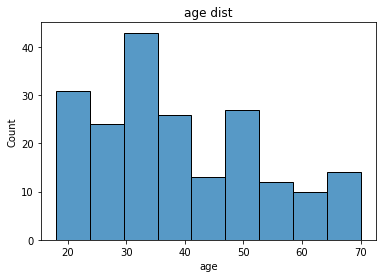

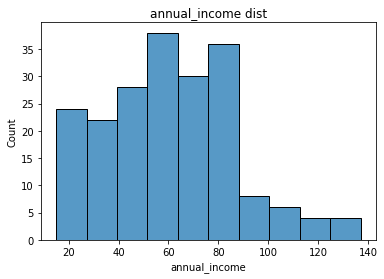

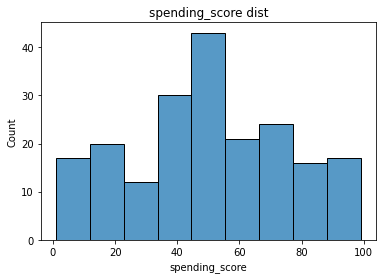

In [12]:
nums = ['age', 'annual_income', 'spending_score']

for col in nums:
    sns.histplot(data=df, x=col)
    plt.title(col+' dist')
    plt.show()

#### Takeaways

 - slight inbalance in gender
 - age and annual income is right skewed
 - spending score is normally distributed

### Q2. Does the spending score differ across gender?

I am now comparing variables, so I HAVE to use the train dataset.

> - what type of variable is spending_score? continuous
> - what type of variable is gender? categorical

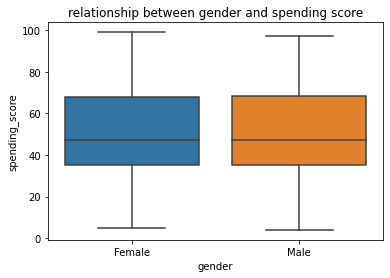

In [14]:
sns.boxplot(data=train, x='gender', y='spending_score')
plt.title('relationship between gender and spending score')
plt.show()

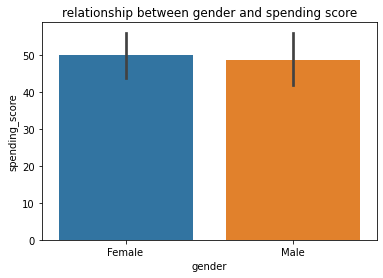

In [15]:
sns.barplot(data=train, x='gender', y='spending_score')
plt.title('relationship between gender and spending score')
plt.show()

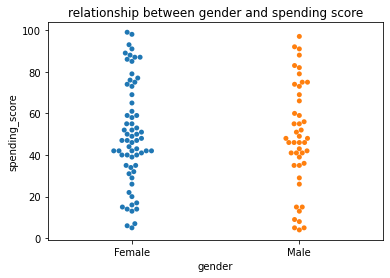

In [17]:
sns.swarmplot(data=train, x='gender', y='spending_score')
plt.title('relationship between gender and spending score')
plt.show()

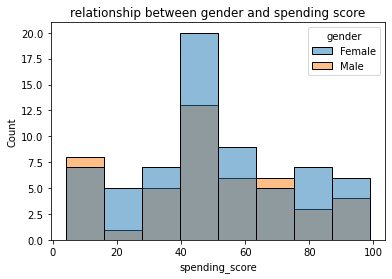

In [16]:
sns.histplot(data=train, hue='gender', x='spending_score')
plt.title('relationship between gender and spending score')
plt.show()

Thoughts

In [18]:
# gender does not affect our spending score

Which stats test to use? 

In [25]:
# Ho --> There is no difference in mean spending score between males and females
# Ha --> There is a difference in mean spending score between males and females

In [19]:
males = train[train.gender == 'Male'].spending_score
females = train[train.gender == 'Female'].spending_score

In [20]:
α = 0.05

In [21]:
#stats.levene()
s, p = stats.levene(males, females)
p < α

False

In [22]:
t, p = stats.ttest_ind(males, females)
p < α

False

In [23]:
#stats.ttest_ind()
# stats.ttest_ind(train[train.gender=='Male'].spending_score, 
#                 train[train.gender=='Female'].spending_score,
#                equal_var=True)

#### Takeaway

In [26]:
# We fail to reject the null hypothesis. Findings suggest there is no difference in the mean spending score between males and females.

### Q3. Is there a relationship between spending score and annual income?

> what type of variable is spending score? continuous   
> what type of variable is annual income? continuous

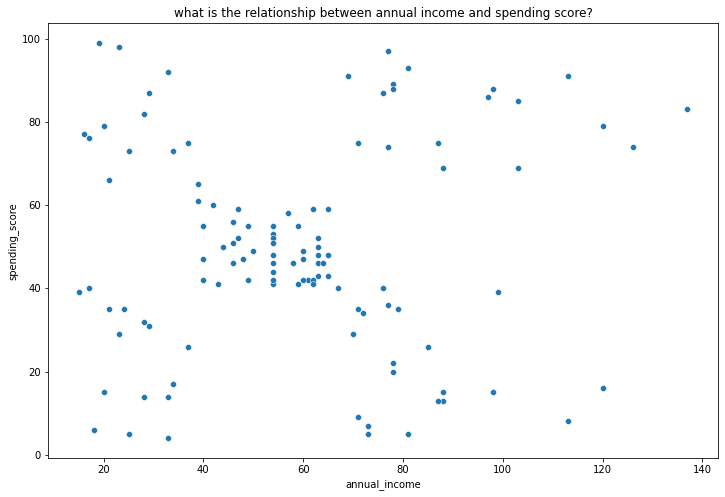

In [28]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=train, x='annual_income', y='spending_score')
plt.title('what is the relationship between annual income and spending score?')
plt.show()

Thoughts

- not a linear relationship
- big X shape
- seem to be clusters!

Which stats test to use? 


- Spearmans correlation test! because we have 2 continuous variables that are not normally distributed

Spearmean R


- Ho --> There is no linear correlation between annual income and spending score
- Ha --> There is a linear correlation between annual income and spending score

In [29]:
stats.spearmanr(train.annual_income, train.spending_score)

SpearmanrResult(correlation=0.0139166413882597, pvalue=0.8842097894086705)

P value is high, so we fail to reject the null hypothesis, findings suggest there is no linear correlation with annual income and spending score

#### Takeaways

- There is no linear correlation between annual income and spending score
- there doe appear to be some kind of non-linear relationship

### Q4. Is there a relationship between age and spending score? 

> what type of variable is age? continuous    
> what type of variable is spending score? continuous

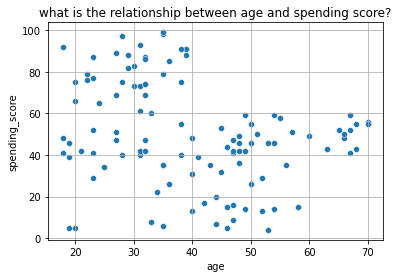

In [33]:
sns.scatterplot(data=train, x='age', y='spending_score')
plt.title('what is the relationship between age and spending score?')
plt.grid()
plt.show()

Thoughts

We'll use `pd.cut()` to make bins

In [47]:
#make new age_bin column
train['age_bins'] = pd.cut(train.age, bins=[0,40,80], labels=['under40', 'over40'])

In [48]:
train.head()

,gender,age,annual_income,spending_score,is_male,age_scaled,annual_income_scaled,age_bins
customer_id,,,,,,,,
27,Female,45,28,32,0,0.519231,0.106557,over40
24,Male,31,25,73,1,0.250000,0.081967,under40
40,Female,20,37,75,0,0.038462,0.180328,under40
38,Female,30,34,73,0,0.230769,0.155738,under40
57,Female,51,44,50,0,0.634615,0.237705,over40


In [49]:
train.age_bins.value_counts()

under40    62
over40     50
Name: age_bins, dtype: int64

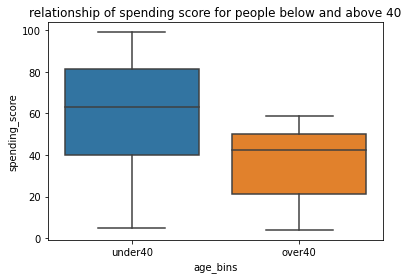

In [50]:
sns.boxplot(data=train, x='age_bins', y='spending_score')
plt.title('relationship of spending score for people below and above 40')
plt.show()

Which stats test to use? T-test! two-sample, two-tailed


In [55]:
under = train[train.age_bins == 'under40'].spending_score
over = train[train.age_bins == 'over40'].spending_score

Levene test

In [58]:
α = 0.05

In [61]:
s, p = stats.levene(under, over)

In [62]:
p < α

True

> our pvalue is less than alpha, therefore we reject the null hypothesis 

> our variances are not equal

In [63]:
stats.ttest_ind(under, over, equal_var=False)

Ttest_indResult(statistic=5.292725484839427, pvalue=6.652618486151613e-07)

> our pvalue is less than alpha, therefore we reject the null hypothesis

> Findings suggest there is a difference in mean spending score between under 40 and over 40 age

#### Takeaway

- there is a difference in spending for people over 40 and under 40

### Q. If we control for age, does spending score differ across annual income?

Use `sns.relplot` to control for variables

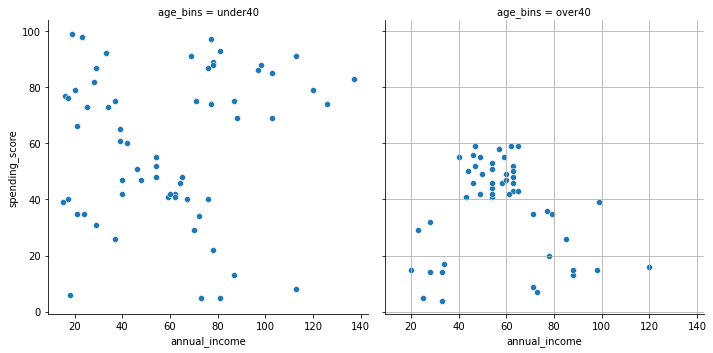

In [66]:
sns.relplot(data=train, x='annual_income', y='spending_score', col='age_bins')
plt.grid()
plt.show()

Thoughts


- customers over 40 are cut off around 60 for spending score
- customers over 40 have a lower half X shape
- 

In [67]:
#create age bins in col


# plt.suptitle("Do the different decades account for the upper vs lower extremes?")
# plt.tight_layout()

Thoughts

#### Does gender play a role?

In [68]:

# plt.suptitle("Do the different decades account for the upper vs lower extremes?")
# plt.tight_layout()

Thoughts


#### Takeaways


### Q. If we control for annual income, does spending score differ across age?

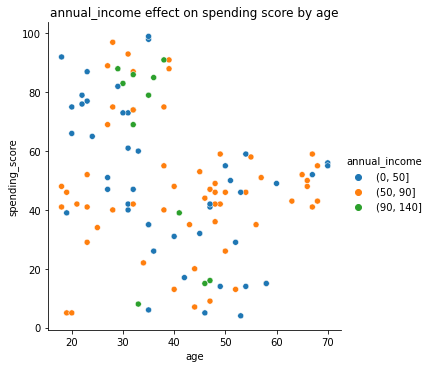

In [74]:
sns.relplot(data=train, x='age', y='spending_score', hue=pd.cut(train.annual_income, bins=[0,50,90,140]))
plt.title('annual_income effect on spending score by age')
plt.show()

Takeaways


In [75]:
# when accounting for income, the relationships do not change

### If you don't know where to start, start with pairplot

Interaction of variables along with income bins


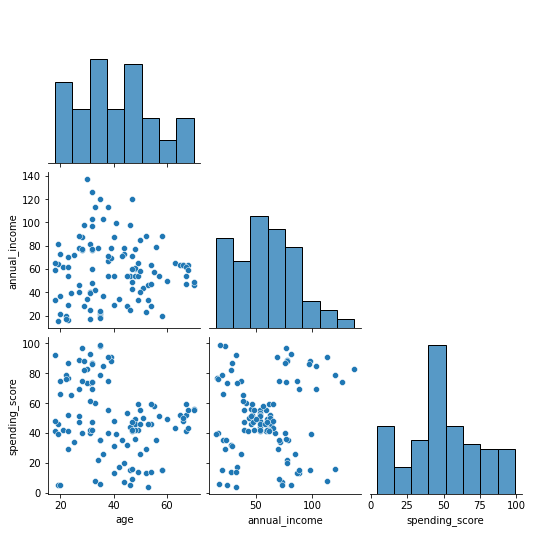

In [79]:
print("Interaction of variables along with income bins")
sns.pairplot(data=train[['age','annual_income','spending_score','gender']], corner=True)
plt.show()

Interaction of variables by gender


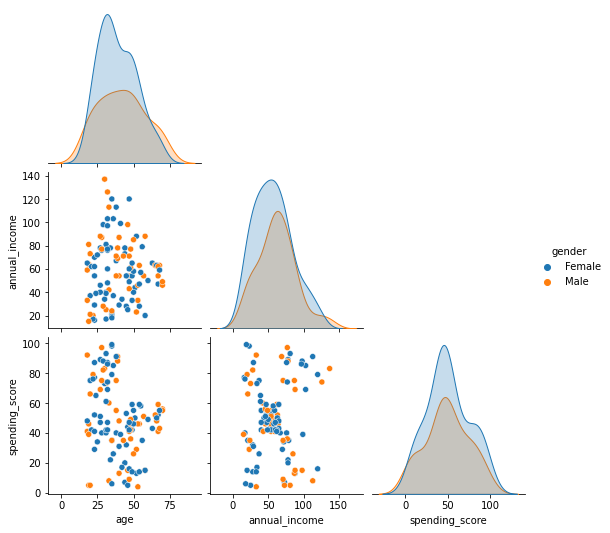

In [82]:
print("Interaction of variables by gender")
sns.pairplot(data=train[['age','annual_income','spending_score','gender']], hue='gender', corner=True)
plt.show()

Interaction of variables by bin


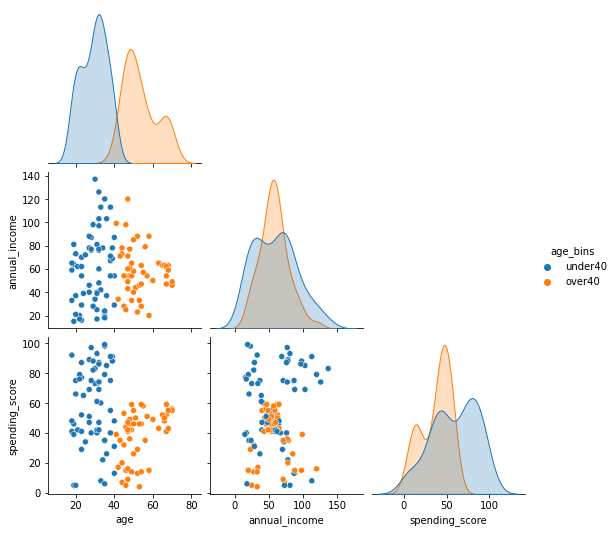

In [83]:
print("Interaction of variables by bin")
sns.pairplot(data=train[['age','annual_income','spending_score','age_bins']], hue='age_bins', corner=True)
plt.show()

## Conclusion



- age is important
- saw more with binning age
- saw gender did not have an impact